In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

In [16]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [17]:
input_img = tf.keras.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [18]:
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [20]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop]
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.4216 - val_loss: 0.3225
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.3182 - val_loss: 0.3155
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.3118 - val_loss: 0.3117
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.3090 - val_loss: 0.3099
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.3078 - val_loss: 0.3089
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.3065 - val_loss: 0.3079
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.3053 - val_loss: 0.3071
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.3058 - val_loss: 0.3064
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.3044 - val_loss: 0.3059
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.3040 - val_loss: 0.3056
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.3034 - val_loss: 0.3052
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 

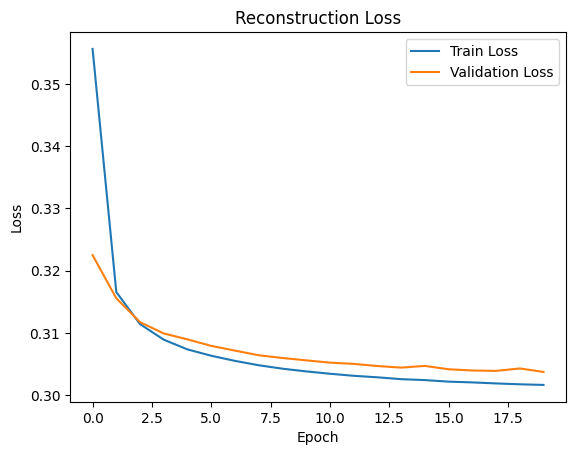

In [21]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
decoded_imgs = autoencoder.predict(x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


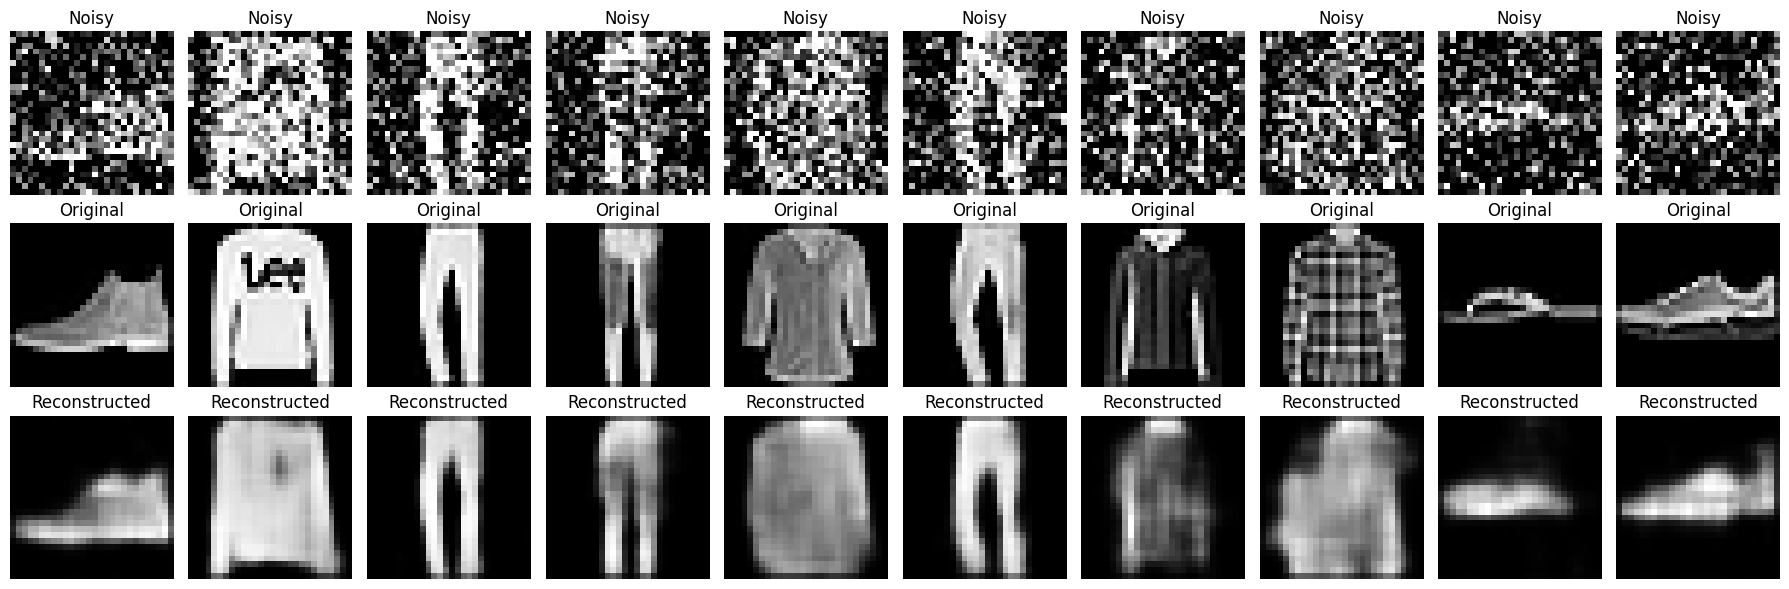

In [23]:
n = 10
plt.figure(figsize=(18, 6))
for i in range(n):
    # Noisy
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Original
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


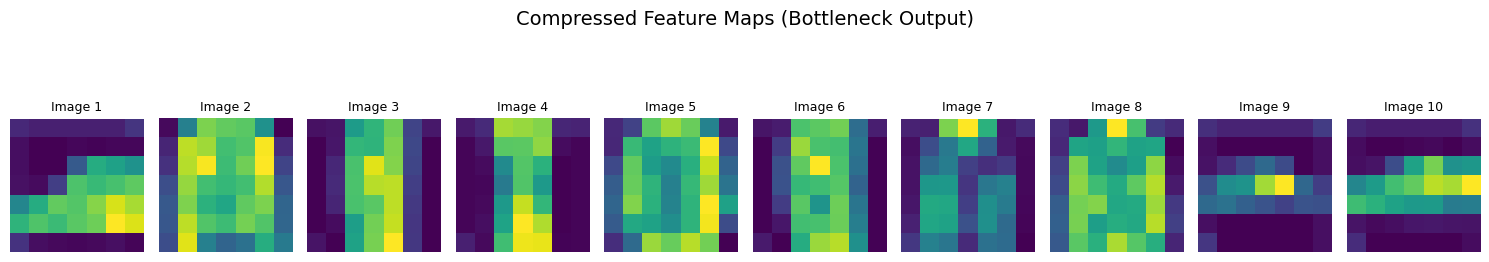

In [25]:
encoder = models.Model(input_img, encoded)
n = 10
encoded_imgs = encoder.predict(x_test[:n])  
plt.figure(figsize=(15, 3))

for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    compressed_image = np.mean(encoded_imgs[i], axis=-1)
    plt.imshow(compressed_image, cmap='viridis')
    plt.title(f"Image {i+1}", fontsize=9)
    plt.axis('off')

plt.suptitle("Compressed Feature Maps (Bottleneck Output)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


## Model Architecture

Built using Convolutional Layers, which are better for image data.

- Encoder:

    - 2 Conv + MaxPooling layers

    - Compresses input image from 28×28 to 7×7×8

- Decoder:

    - 2 Conv + UpSampling layers

    - Reconstructs the image back to 28×28

- Activation:

    - ReLU in hidden layers

    - Sigmoid in the output (since image pixels are in [0, 1])

## Training Setup

- Optimizer: Adam

- Loss function: Binary Crossentropy

- EarlyStopping used to prevent overfitting.

- Model is trained on noisy images with the goal to reconstruct clean images.

## Bottleneck Layer (Feature Extraction)
                             
- The compressed 7x7x8 features (bottleneck) are visualized.

- Shows what important features the model "sees" and keeps during compression.

## Result and Interpretation
    
1. Reconstruction Quality
    
    - The reconstructed (denoised) images look very similar to the original clean ones.

    - Shows the model has successfully learned to remove noise.

2. Loss Graph
    
    - Both training and validation loss decrease over time.

    - Shows the model is learning properly and not overfitting.

3. Bottleneck Features
    
    - The encoded feature maps show a compressed version of the input.

    - It proves the model is learning to keep the important parts of the image.

## Conclusion
    
- The model learns to clean noisy images very well using convolutional autoencoders.

- The results show strong reconstruction from noise.